<a href="https://colab.research.google.com/github/Rishikesh623/Data_Mining/blob/main/Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

0.8235294117647058


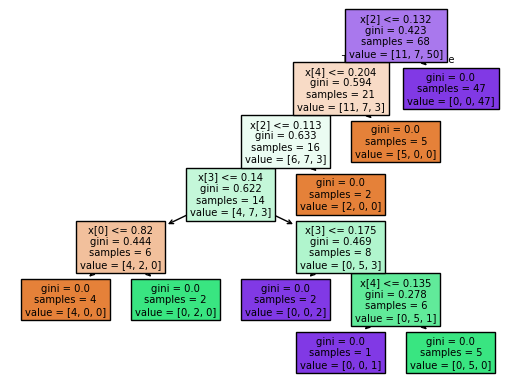

In [ ]:
import pandas as pd
df = pd.read_csv("vehicle.csv")

df.dropna()

from sklearn.tree import DecisionTreeClassifier,plot_tree
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from mlxtend.preprocessing import TransactionEncoder
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

Class = "origin"
X = df.drop(["name",Class],axis=1)
y = df[Class]

X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state=42)

scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.fit_transform(X_test)

model = DecisionTreeClassifier(random_state=42)
model.fit(X_train,y_train)

y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test,y_pred)
print(accuracy)

plot_tree(model,filled=True)
plt.show()

In [ ]:
from collections import Counter

In [ ]:

def entropy(y):
    counts = Counter(y)
    total = len(y)
    return -sum((count/total) * np.log2(count/total) for count in counts.values())

def info_gain(data, feature, target):
    values = sorted(data[feature].unique())
    best_gain = 0
    best_split = None
    total_entropy = entropy(data[target])

    for val in values:
        left = data[data[feature] <= val]
        right = data[data[feature] > val]

        if len(left) == 0 or len(right) == 0:
            continue

        p = len(left) / len(data)
        gain = total_entropy - (p * entropy(left[target]) + (1 - p) * entropy(right[target]))

        if gain > best_gain:
            best_gain = gain
            best_split = val

    return best_split, best_gain

def gini_index(groups, target):
    n_instances = sum(len(group) for group in groups)
    gini = 0.0
    for group in groups:
        size = len(group)
        if size == 0:
            continue
        score = 0.0
        counts = Counter(group[target])
        for lbl in counts:
            p = counts[lbl] / size
            score += p * p
        gini += (1 - score) * (size / n_instances)
    return gini

def best_split_gini(data, feature, target):
    values = sorted(data[feature].unique())
    best_gini = 1
    best_split = None

    for val in values:
        left = data[data[feature] <= val]
        right = data[data[feature] > val]

        gini = gini_index([left, right], target)
        if gini < best_gini:
            best_gini = gini
            best_split = val

    return best_split, best_gini


def gain_ratio(data, feature, target):
    values = sorted(data[feature].unique())
    best_ratio = 0
    best_split = None
    total_entropy = entropy(data[target])

    for val in values:
        left = data[data[feature] <= val]
        right = data[data[feature] > val]
        if len(left) == 0 or len(right) == 0:
            continue

        p = len(left) / len(data)
        gain = total_entropy - (p * entropy(left[target]) + (1 - p) * entropy(right[target]))

        split_info = -p * np.log2(p) - (1 - p) * np.log2(1 - p)
        ratio = gain / split_info if split_info != 0 else 0

        if ratio > best_ratio:
            best_ratio = ratio
            best_split = val

    return best_split, best_ratio


In [ ]:

features = [col for col in df.columns if col != Class]

print("Split Points for Each Attribute:\n")
for feature in features:
    ig_split, ig_value = info_gain(df, feature, Class)
    gini_split, gini_value = best_split_gini(df, feature, Class)
    gr_split, gr_value = gain_ratio(df, feature, Class)

    print(f"Attribute: {feature}")
    print(f"  Information Gain -> Split: {ig_split}, Gain: {ig_value:.4f}")
    print(f"  Gini Index       -> Split: {gini_split}, Gini: {gini_value:.4f}")
    print(f"  Gain Ratio       -> Split: {gr_split}, Ratio: {gr_value:.4f}")



Split Points for Each Attribute:

Attribute: name
  Information Gain -> Split: 'pontiac safari (sw)', Gain: 0.2859
  Gini Index       -> Split: 'pontiac safari (sw)', Gini: 0.3119
  Gain Ratio       -> Split: 'pontiac safari (sw)', Ratio: 0.5144
--------------------------------------------------
Attribute: fuel_efficiency
  Information Gain -> Split: 22, Gain: 0.3650
  Gini Index       -> Split: 22, Gini: 0.2810
  Gain Ratio       -> Split: 30, Ratio: 0.4719
--------------------------------------------------
Attribute: cylinders
  Information Gain -> Split: 4, Gain: 0.4987
  Gini Index       -> Split: 4, Gini: 0.2567
  Gain Ratio       -> Split: 4, Ratio: 0.5175
--------------------------------------------------
Attribute: displacement
  Information Gain -> Split: 121.0, Gain: 0.6501
  Gini Index       -> Split: 121.0, Gini: 0.1935
  Gain Ratio       -> Split: 121.0, Ratio: 0.7209
--------------------------------------------------
Attribute: horsepower
  Information Gain -> Split: 97.0

In [ ]:
class TreeNode:
    def __init__(self, feature=None, threshold=None, branches=None, label=None):
        self.feature = feature
        self.threshold = threshold
        self.branches = branches or {}
        self.label = label


In [ ]:
def build_binary_tree(data, target, depth=0, max_depth=5):
    from collections import Counter

    if len(set(data[target])) == 1 or depth == max_depth:
        label = data[target].mode()[0]
        return TreeNode(label=label)

    best_feature, best_split, best_gain = None, None, 0
    total_entropy = entropy(data[target])

    for feature in data.columns:
        if feature == target:
            continue
        split,gain = info_gain(data, feature, target)
        if gain > best_gain:
            best_gain = gain
            best_feature = feature
            best_split = split

    if best_gain == 0:
        return TreeNode(label=data[target].mode()[0])

    left_data = data[data[best_feature] <= best_split]
    right_data = data[data[best_feature] > best_split]

    left_branch = build_binary_tree(left_data, target, depth+1, max_depth)
    right_branch = build_binary_tree(right_data, target, depth+1, max_depth)

    node = TreeNode(feature=best_feature, threshold=best_split)
    node.branches['<='] = left_branch
    node.branches['>'] = right_branch
    return node


In [ ]:
def build_general_tree(data, target, depth=0, max_depth=5):

    if len(set(data[target])) == 1 or depth == max_depth:
        return TreeNode(label=data[target].mode()[0])

    best_feature, best_gain = None, 0
    total_entropy = entropy(data[target])

    for feature in data.columns:
        if feature == target:
            continue
        grouped = data.groupby(feature)
        gain = total_entropy
        for _, subset in grouped:
            gain -= (len(subset) / len(data)) * entropy(subset[target])
        if gain > best_gain:
            best_gain = gain
            best_feature = feature

    if best_feature is None:
        return TreeNode(label=data[target].mode()[0])

    node = TreeNode(feature=best_feature)
    for val, subset in data.groupby(best_feature):
        node.branches[val] = build_general_tree(subset.drop(columns=[best_feature]), target, depth+1, max_depth)

    return node


In [ ]:
from graphviz import Digraph

def visualize_tree(node, dot=None, parent=None, edge_label=''):
    if dot is None:
        dot = Digraph()
        dot.node('root', label=str(node.feature if node.label is None else f'Label: {node.label}'))
        root = 'root'a
    else:
        root = str(id(node))
        label = node.feature if node.label is None else f'Label: {node.label}'
        dot.node(root, label=str(label))
        dot.edge(parent, root, label=str(edge_label))

    if node.label is None:
        for cond, child in node.branches.items():
            visualize_tree(child, dot, root, cond)
    return dot


In [ ]:
#Binary Tree
binary_root = build_binary_tree(df, target=Class, max_depth=3)
dot_binary = visualize_tree(binary_root)
dot_binary.render('binary_tree', view=True)

#General Tree (nominal)
general_root = build_general_tree(df, target=Class, max_depth=3)
dot_general = visualize_tree(general_root)
dot_general.render('general_tree', view=True)


'general_tree.pdf'

In [ ]:
def predict_binary(node, sample):
    while node.label is None:
        val = sample[node.feature]
        if val <= node.threshold:
            node = node.branches['<=']
        else:
            node = node.branches['>']
    return node.label


In [ ]:
def predict_general(node, sample):
    while node.label is None:
        val = sample.get(node.feature)
        if val in node.branches:
            node = node.branches[val]
        else:
            return "Unknown"
    return node.label


In [ ]:
def predict_batch(tree, df, mode='binary'):
    if mode == 'binary':
        return df.apply(lambda row: predict_binary(tree, row), axis=1)
    else:
        return df.apply(lambda row: predict_general(tree, row), axis=1)


In [ ]:

sample = df.iloc[0]
print("Binary Prediction:", predict_binary(binary_root, sample))
print("General Prediction:", predict_general(general_root, sample))


predictions = predict_batch(binary_root, df, mode='binary')
print(predictions)


Binary Prediction: usa
General Prediction: usa
0        usa
1        usa
2        usa
3      japan
4     europe
       ...  
80       usa
81       usa
82       usa
83       usa
84       usa
Length: 85, dtype: object


In [ ]:
print(accuracy_score(df[Class], predictions))

0.9058823529411765
